### Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [2]:
# Preprocessing of Numerical and Categorical Data
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import compose
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, KBinsDiscretizer

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score



In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Read Data
Main: rentals_dataset.csv

Supplemented datasets:
1. hdb_rentals
2. hdb_locations
3. train_locations
4. mrt_locations
5. busstop_locations
6. school_locations
7. moeschools (Generalinformationofschools.csv)
8. intschool_locations
9. shopping_locations

Other Available Datasets:
- hdb_mapping_price_per_sqm.csv
- hdb_mapping_units.csv
- hdb_rentals.csv
- hdb_resales.csv
- mrt_lrt_data.csv
- new_resales.csv
- old_resales.csv

In [4]:
rentals_dataset = pd.read_csv('rentals_dataset.csv', index_col=0)

In [5]:
#Check for Missing Values
print(rentals_dataset.isna().any()) 

date                  False
town                  False
block                 False
street_name           False
flat_type             False
monthly_rent          False
flat_type_group       False
region                False
lat                   False
lng                   False
postal                False
property_age          False
avg_floor_area_sqm    False
price_sqm             False
nearest_mrt           False
mrt_dist              False
nearest_shopping      False
shopping_dist         False
nearest_intschool     False
intschool_dist        False
nearest_hawker        False
hawker_dist           False
dtype: bool


### Data Preprocessing

Identify useful features and drop unnecessary features from the df

In [6]:
from datetime import datetime

# Transform date to more usable format
rentals_dataset['date'] = pd.to_datetime(rentals_dataset['date'])
reference_date = datetime(2023, 12, 31)
rentals_dataset['year'] = rentals_dataset['date'].dt.year

# Calculate the difference in months
rentals_dataset['months_since_signedrental'] = (
    (rentals_dataset['date'].dt.year - reference_date.year) * 12 +
    (rentals_dataset['date'].dt.month - reference_date.month)
)
rentals_dataset.head()

,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,...,nearest_mrt,mrt_dist,nearest_shopping,shopping_dist,nearest_intschool,intschool_dist,nearest_hawker,hawker_dist,year,months_since_signedrental
0,2021-01-01,ANG MO KIO,105,ANG MO KIO AVE 4,4 ROOM,2000,4-ROOM,Northeast,1.372313,103.837601,...,Yio Chu Kang,1.329716,Broadway Plaza,0.929260,NANYANG POLYTECHNIC,1.529100,Blks 160/162 Ang Mo Kio Ave 4,0.244028,2021,-35
1,2021-01-01,ANG MO KIO,107,ANG MO KIO AVE 4,3 ROOM,1750,3-ROOM,Northeast,1.371384,103.837381,...,Ang Mo Kio,1.365741,Broadway Plaza,0.954735,NANYANG POLYTECHNIC,1.607337,Blks 160/162 Ang Mo Kio Ave 4,0.344891,2021,-35
2,2021-01-01,ANG MO KIO,108,ANG MO KIO AVE 4,3 ROOM,1750,3-ROOM,Northeast,1.370966,103.838202,...,Ang Mo Kio,1.270434,Broadway Plaza,0.868254,NANYANG POLYTECHNIC,1.562581,Blks 160/162 Ang Mo Kio Ave 4,0.357068,2021,-35
3,2021-01-01,ANG MO KIO,111,ANG MO KIO AVE 4,5 ROOM,2230,5-ROOM,Northeast,1.370851,103.837298,...,Ang Mo Kio,1.369690,Broadway Plaza,0.969552,NANYANG POLYTECHNIC,1.649779,Blks 160/162 Ang Mo Kio Ave 4,0.401847,2021,-35
4,2021-01-01,ANG MO KIO,111,ANG MO KIO AVE 4,5 ROOM,2450,5-ROOM,Northeast,1.370851,103.837298,...,Ang Mo Kio,1.369690,Broadway Plaza,0.969552,NANYANG POLYTECHNIC,1.649779,Blks 160/162 Ang Mo Kio Ave 4,0.401847,2021,-35


In [7]:
# Reduced data set to drop columns that might not be useful for the initial model
reduced_df = rentals_dataset.drop(columns=['date','block','flat_type_group', 'postal','region', 'street_name','lat','lng',
                                          'nearest_mrt','nearest_intschool','nearest_shopping','nearest_hawker',
                                           'price_sqm'
                                         ])

reduced_df.head()

,town,flat_type,monthly_rent,property_age,avg_floor_area_sqm,mrt_dist,shopping_dist,intschool_dist,hawker_dist,year,months_since_signedrental
0,ANG MO KIO,4 ROOM,2000,45.0,92.0,1.329716,0.929260,1.529100,0.244028,2021,-35
1,ANG MO KIO,3 ROOM,1750,45.0,78.2,1.365741,0.954735,1.607337,0.344891,2021,-35
2,ANG MO KIO,3 ROOM,1750,45.0,74.5,1.270434,0.868254,1.562581,0.357068,2021,-35
3,ANG MO KIO,5 ROOM,2230,45.0,117.0,1.369690,0.969552,1.649779,0.401847,2021,-35
4,ANG MO KIO,5 ROOM,2450,45.0,117.0,1.369690,0.969552,1.649779,0.401847,2021,-35


Convert Categorical Variables using one-hot encoding

In [8]:
# Identify Categorical Features
cat_features = reduced_df.select_dtypes(include=['object']).columns.tolist()
cat_features_idx = [reduced_df.columns.get_loc(col) for col in cat_features]
categorical_cols = reduced_df.select_dtypes(include=['object']).columns
categorical_cols

Index(['town', 'flat_type'], dtype='object')

In [9]:
# Identify Numerical Features
distance_cols = reduced_df.select_dtypes(exclude=['object']).columns
distance_cols = distance_cols.drop(['monthly_rent','property_age','year','months_since_signedrental','avg_floor_area_sqm'])
dist_features = distance_cols.to_list()
dist_features_idx = [reduced_df.columns.get_loc(col) for col in dist_features]
distance_cols

Index(['mrt_dist', 'shopping_dist', 'intschool_dist', 'hawker_dist'], dtype='object')

## Data Modeling

In [10]:
rng = np.random.RandomState(42)  # Use this as a random_state input for machine learning models

In [11]:
# Create the ColumnTransformer to apply different preprocessing to different columns
preprocessor = ColumnTransformer(
    transformers=[
        #('scaler', StandardScaler(), distance_cols),
        ('onehot_encoder', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough')

# Apply the preprocessing to the training data
preprocessed_df = preprocessor.fit_transform(reduced_df)


def get_feature_names(column_transformer):
    """Get feature names from a ColumnTransformer, including 'remainder' features"""
    output_features = []
    
    # Loop through each transformer
    for name, transformer, original_features in column_transformer.transformers_:
        if name == 'remainder':
            # If 'remainder', add the feature names directly
            if transformer == 'passthrough':
                remainder_cols = column_transformer.feature_names_in_[original_features]
                output_features.extend(remainder_cols)
            continue

        if hasattr(transformer, 'get_feature_names_out'):
            # For transformers with 'get_feature_names_out' method (like OneHotEncoder)
            transformed_features = transformer.get_feature_names_out(original_features)
        else:
            # If the transformer does not have such a method (like StandardScaler)
            transformed_features = original_features

        # Append the transformed feature names to the output list
        output_features.extend(transformed_features)
    
    return output_features

# Get all feature names
feature_names = get_feature_names(preprocessor)

preprocessed_df = pd.DataFrame(preprocessed_df.toarray() , columns=feature_names) #.toarray() 
preprocessed_df.columns = preprocessed_df.columns.str.replace(' ','_')
preprocessed_df = preprocessed_df.rename(columns={'town_KALLANG/WHAMPOA':'town_KALLANG_WHAMPOA'})
preprocessed_df = preprocessed_df.drop(columns = ['town_ANG_MO_KIO','flat_type_1_ROOM'])

# Split dataset into features and target
X = preprocessed_df.drop('monthly_rent', axis=1).reset_index(drop = True)
y = preprocessed_df['monthly_rent'].reset_index(drop = True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)

#### Predictions with OLS Regression
> Identify which features is significant to monthly rents

In [12]:
est = sm.OLS( y, sm.add_constant( X ) ).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           monthly_rent   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     3018.
Date:                Tue, 09 Apr 2024   Prob (F-statistic):               0.00
Time:                        02:59:57   Log-Likelihood:            -7.9744e+05
No. Observations:              104604   AIC:                         1.595e+06
Df Residuals:                  104565   BIC:                         1.595e+06
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -2.001e+05   1.14e+04    -17.489      0.000   -2.23e+05   -1.78e+05
town_BEDOK                  -55.6071      9.207     -6.039      0.000     -73.654     -37.561
town_BISHAN                 143.6187     12.039     11.930      0.000     120.023     167.215
town_BUKIT_BATOK           -145.2210     11.195    -12.972      0.000    -167.162    -123.280
town_BUKIT_MERAH            269.1973      9.968     27.006      0.000     249.660     288.734
town_BUKIT_PANJANG         -272.6643     13.718    -19.876      0.000    -299.551    -245.777
town_BUKIT_TIMAH            189.5767     28.413      6.672      0.000     133.887     245.267
town_CENTRAL                441.8859     14.900     29.657      0.000     412.683     471.089
town_CHOA_CHU_KANG         -353.7000     12.873    -27.476      0.000    -378.931    -328.469
town_CLEMENTI               163.9281     10.370     15.809      0.000     143.604     184.252
town_GEYLANG                  3.5075     12.436      0.282      0.778     -20.867      27.882
town_HOUGANG               -182.5441     10.428    -17.505      0.000    -202.983    -162.105
town_JURONG_EAST            -31.3157     11.422     -2.742      0.006     -53.702      -8.929
town_JURONG_WEST           -190.7500      9.261    -20.597      0.000    -208.901    -172.599
town_KALLANG_WHAMPOA        111.0621     10.921     10.170      0.000      89.657     132.467
town_MARINE_PARADE          347.2098     17.634     19.690      0.000     312.647     381.773
town_PASIR_RIS              -88.1679     14.468     -6.094      0.000    -116.524     -59.812
town_PUNGGOL               -116.7537     18.396     -6.347      0.000    -152.810     -80.697
town_QUEENSTOWN             307.4828     11.100     27.700      0.000     285.726     329.240
town_SEMBAWANG             -405.0461     13.617    -29.745      0.000    -431.736    -378.357
town_SENGKANG              -206.9739     13.775    -15.025      0.000    -233.973    -179.975
town_SERANGOON               55.2978     12.395      4.461      0.000      31.004      79.592
town_TAMPINES               -90.7160      9.494     -9.556      0.000    -109.323     -72.109
town_TOA_PAYOH               93.3982     10.318      9.052      0.000      73.176     113.620
town_WOODLANDS             -357.0997     10.700    -33.372      0.000    -378.072    -336.127
town_YISHUN                -228.5926      9.824    -23.269      0.000    -247.847    -209.338
flat_type_2_ROOM            280.9443     96.626      2.908      0.004      91.559     470.330
flat_type_3_ROOM            755.0283     96.160      7.852      0.000     566.557     943.500
flat_type_4_ROOM           1074.7535     97.161     11.062      0.000     884.320    1265.187
flat_type_5_ROOM           1178.9735     98.373     11.985      0.000     9

In [13]:
original_col = pd.get_dummies(reduced_df).columns
rentals_reg = pd.get_dummies(reduced_df, drop_first=True)
dummy_var = set(original_col) - set(rentals_reg.columns)
rentals_reg.columns = rentals_reg.columns.str.replace(' ','_')
rentals_reg = rentals_reg.rename(columns={'town_KALLANG/WHAMPOA':'town_KALLANG_WHAMPOA'})
rentals_reg

,monthly_rent,property_age,avg_floor_area_sqm,mrt_dist,shopping_dist,intschool_dist,hawker_dist,year,months_since_signedrental,town_BEDOK,...,town_SERANGOON,town_TAMPINES,town_TOA_PAYOH,town_WOODLANDS,town_YISHUN,flat_type_2_ROOM,flat_type_3_ROOM,flat_type_4_ROOM,flat_type_5_ROOM,flat_type_EXECUTIVE
0,2000,45.0,92.0,1.329716,0.929260,1.529100,0.244028,2021,-35,False,...,False,False,False,False,False,False,False,True,False,False
1,1750,45.0,78.2,1.365741,0.954735,1.607337,0.344891,2021,-35,False,...,False,False,False,False,False,False,True,False,False,False
2,1750,45.0,74.5,1.270434,0.868254,1.562581,0.357068,2021,-35,False,...,False,False,False,False,False,False,True,False,False,False
3,2230,45.0,117.0,1.369690,0.969552,1.649779,0.401847,2021,-35,False,...,False,False,False,False,False,False,False,False,True,False
4,2450,45.0,117.0,1.369690,0.969552,1.649779,0.401847,2021,-35,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109314,4100,23.0,89.3,0.623560,0.786134,0.591196,0.782664,2023,0,False,...,False,False,False,False,False,False,False,True,False,False
109315,3300,23.0,103.0,0.296640,0.232765,2.184021,2.932362,2023,0,False,...,False,False,False,True,False,False,False,True,False,False
109316,2950,30.0,106.2,0.319505,0.327919,2.742494,0.661868,2023,0,False,...,False,False,False,False,False,False,False,True,False,False
109317,3200,36.0,86.5,0.885971,0.964711,1.233403,0.635330,2023,0,False,...,False,False,False,False,True,False,False,True,False,False


In [14]:
x_variables = list(rentals_reg.columns)
y_variable = 'monthly_rent'

try: x_variables.remove(y_variable)
except ValueError: pass
    
linear_model = smf.ols(data=rentals_reg, formula=f'{y_variable} ~ {"+".join(x_variables)}').fit()
print(linear_model.summary())
print(dummy_var)

                            OLS Regression Results                            
Dep. Variable:           monthly_rent   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     3018.
Date:                Tue, 09 Apr 2024   Prob (F-statistic):               0.00
Time:                        02:59:57   Log-Likelihood:            -7.9744e+05
No. Observations:              104604   AIC:                         1.595e+06
Df Residuals:                  104565   BIC:                         1.595e+06
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

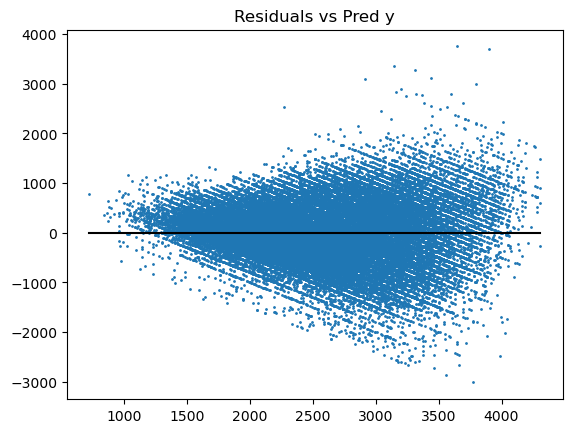

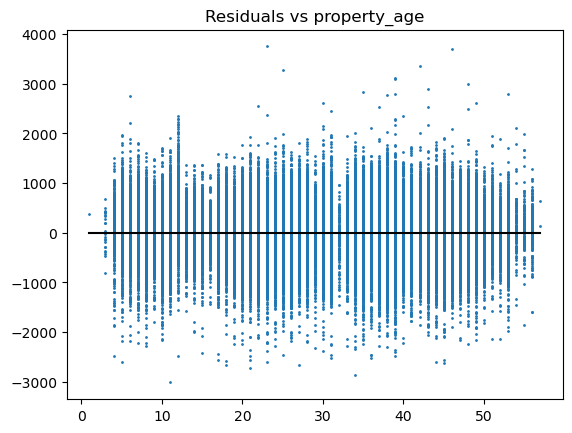

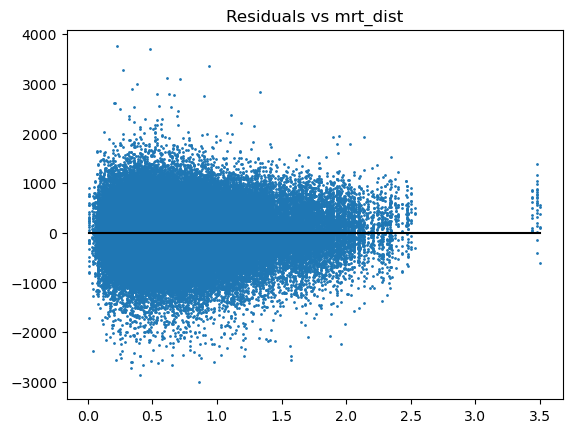

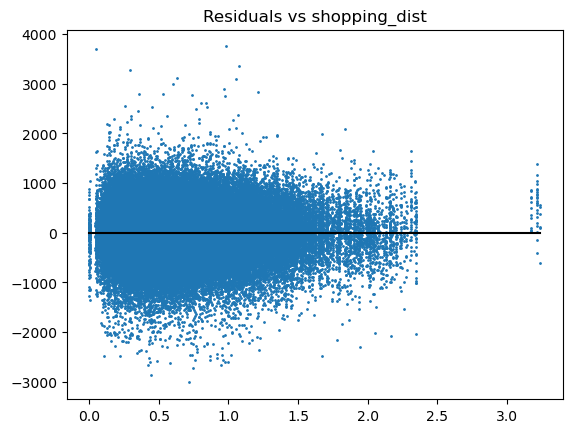

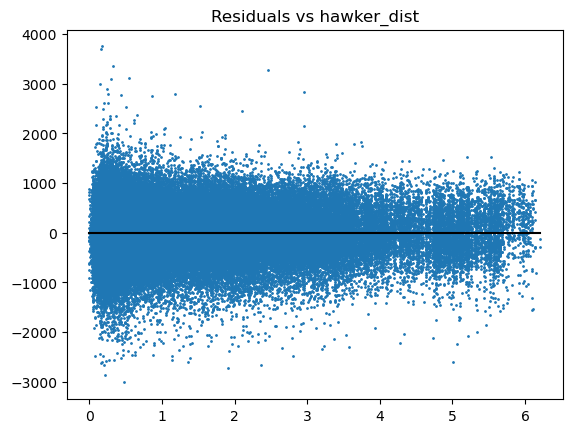

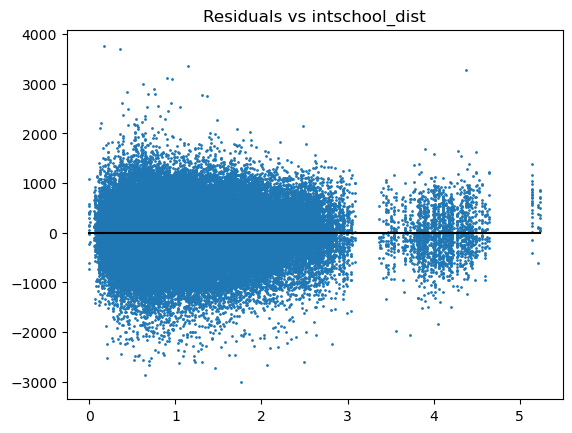

In [15]:

''' Residual Analysis for Heteroscedasticity '''

pred_y = linear_model.fittedvalues
plt.scatter(pred_y, linear_model.resid, s=1)
plt.plot([min(pred_y),max(pred_y)],[0,0], color='black')
plt.title('Residuals vs Pred y')
plt.show()

for var in ['property_age', 'mrt_dist','shopping_dist','hawker_dist','intschool_dist']:
    plt.scatter(preprocessed_df[var], linear_model.resid, s=1)
    plt.plot([min(preprocessed_df[var]),max(preprocessed_df[var])],[0,0], color='black')
    plt.title(f'Residuals vs {var}')
    plt.show()


In [16]:
# Apply a log transformation to the target variable y
y_transformed = np.log(y)

# Fit the OLS model with the log-transformed y
est = sm.OLS(y_transformed, sm.add_constant(X)).fit()
est.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           monthly_rent   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     2820.
Date:                Tue, 09 Apr 2024   Prob (F-statistic):               0.00
Time:                        02:59:58   Log-Likelihood:                 22165.
No. Observations:              104604   AIC:                        -4.425e+04
Df Residuals:                  104565   BIC:                        -4.388e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       -61.3348      4.526    -13.552      0.000     -70.206     -52.464
town_BEDOK                   -0.0214      0.004     -5.875      0.000      -0.029      -0.014
town_BISHAN                   0.0556      0.005     11.668      0.000       0.046       0.065
town_BUKIT_BATOK             -0.0584      0.004    -13.190      0.000      -0.067      -0.050
town_BUKIT_MERAH              0.1014      0.004     25.730      0.000       0.094       0.109
town_BUKIT_PANJANG           -0.1103      0.005    -20.326      0.000      -0.121      -0.100
town_BUKIT_TIMAH              0.0622      0.011      5.536      0.000       0.040       0.084
town_CENTRAL                  0.1526      0.006     25.893      0.000       0.141       0.164
town_CHOA_CHU_KANG           -0.1362      0.005    -26.747      0.000      -0.146      -0.126
town_CLEMENTI                 0.0633      0.004     15.439      0.000       0.055       0.071
town_GEYLANG                  0.0039      0.005      0.788      0.431      -0.006       0.014
town_HOUGANG                 -0.0718      0.004    -17.408      0.000      -0.080      -0.064
town_JURONG_EAST             -0.0112      0.005     -2.469      0.014      -0.020      -0.002
town_JURONG_WEST             -0.0721      0.004    -19.672      0.000      -0.079      -0.065
town_KALLANG_WHAMPOA          0.0462      0.004     10.696      0.000       0.038       0.055
town_MARINE_PARADE            0.1397      0.007     20.036      0.000       0.126       0.153
town_PASIR_RIS               -0.0356      0.006     -6.221      0.000      -0.047      -0.024
town_PUNGGOL                 -0.0493      0.007     -6.770      0.000      -0.064      -0.035
town_QUEENSTOWN               0.1146      0.004     26.095      0.000       0.106       0.123
town_SEMBAWANG               -0.1522      0.005    -28.253      0.000      -0.163      -0.142
town_SENGKANG                -0.0786      0.005    -14.432      0.000      -0.089      -0.068
town_SERANGOON                0.0242      0.005      4.935      0.000       0.015       0.034
town_TAMPINES                -0.0328      0.004     -8.726      0.000      -0.040      -0.025
town_TOA_PAYOH                0.0341      0.004      8.363      0.000       0.026       0.042
town_WOODLANDS               -0.1417      0.004    -33.490      0.000      -0.150      -0.133
town_YISHUN                  -0.0915      0.004    -23.538      0.000      -0.099      -0.084
flat_type_2_ROOM              0.1943      0.038      5.085      0.000       0.119       0.269
flat_type_3_ROOM              0.4376      0.038     11.507      0.000       0.363       0.512
flat_type_4_ROOM              0.5707      0.038     14.850      0.000       0.495       0.646
flat_type_5_ROOM              0.6099      0.039     15.677      0.000      

### TEST ON OTHER MODELS

In [17]:
# Split dataset into features and target
X2 = rentals_reg.drop('monthly_rent', axis=1).reset_index(drop = True)
y2 = rentals_reg['monthly_rent'].reset_index(drop = True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=rng)

In [18]:
y_test

14973    1900
69203    4000
89311    3400
89487    3200
34397    2400
         ... 
93187    1500
20667    2200
22337    3380
45487    1750
97112    2000
Name: monthly_rent, Length: 20921, dtype: int64

In [19]:
idx_low = y_test[y_test == y_test.min()].idxmax()
#idx_low = y_test.nsmallest(10).index[-1]
idx_mid = y_test[y_test == y_test.median()].idxmax()
idx_high = y_test[y_test == y_test.max()].idxmax()

#### Ridge Regression

In [20]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Define the Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # alpha is the regularization strength

# Fit the model
ridge_model.fit(X_train, y_train)

# Predict
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression - RMSE:", rmse_ridge)
print("Ridge Regression - R² score:", r2_ridge)


Ridge Regression - RMSE: 496.08269561699257
Ridge Regression - R² score: 0.5235253201550263


In [21]:
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(n_splits=5, shuffle=True, random_state=rng)
scores = cross_val_score(ridge_model, X, y, cv=kf, scoring='neg_mean_squared_error')
# The 'scores' will be negative due to the 'neg_mean_squared_error' scoring
# To get the positive mean squared error, take the negative of the scores
mse_scores = -scores

print(f"Mean Squared Error for each fold: {mse_scores}")

average_mse = mse_scores.mean()
print(f"Average Mean Squared Error across all folds: {average_mse}")


Mean Squared Error for each fold: [250129.04243832 245497.60013323 240584.16091713 248463.63721752
 241110.56508791]
Average Mean Squared Error across all folds: 245157.0011588213


In [22]:
# REVIEW PREDICTION - 1 LOW
index = idx_low
print( y_test.loc[[index]] )
print(ridge_model.predict( X_test.loc[[index]] ))

11475    400
Name: monthly_rent, dtype: int64
[972.43350417]


In [23]:
# REVIEW PREDICTION - 2 MID
index = idx_mid
print( y_test.loc[[index]] )
print(ridge_model.predict( X_test.loc[[index]] ))

34397    2400
Name: monthly_rent, dtype: int64
[1878.07249823]


In [24]:
# REVIEW PREDICTION - 3 HIGH
index = idx_high
print( y_test.loc[[index]] )
print(ridge_model.predict( X_test.loc[[index]] ))

81913    6600
Name: monthly_rent, dtype: int64
[3313.94904617]


### Lasso Regression

In [25]:
from sklearn.linear_model import Lasso

# Define the Lasso Regression model
lasso_model = Lasso(alpha=0.1)  # alpha is the regularization strength

# Fit the model
lasso_model.fit(X_train, y_train)

# Predict
y_pred_lasso = lasso_model.predict(X_test)

# Evaluate
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Regression - RMSE:", rmse_lasso)
print("Lasso Regression - R² score:", r2_lasso)


Lasso Regression - RMSE: 496.14973933597065
Lasso Regression - R² score: 0.5233965239143314


In [26]:
# REVIEW PREDICTION - 1 LOW
index = idx_low
print( y_test.loc[[index]] )
print(lasso_model.predict( X_test.loc[[index]] ))

11475    400
Name: monthly_rent, dtype: int64
[979.76228776]


In [27]:
# REVIEW PREDICTION - 2 MID
index = idx_mid
print( y_test.loc[[index]] )
print(lasso_model.predict( X_test.loc[[index]] ))

34397    2400
Name: monthly_rent, dtype: int64
[1883.00444133]


In [28]:
# REVIEW PREDICTION - 3 HIGH
index = idx_high
print( y_test.loc[[index]] )
print(lasso_model.predict( X_test.loc[[index]] ))

81913    6600
Name: monthly_rent, dtype: int64
[3323.98505506]


In [29]:

kf = KFold(n_splits=5, shuffle=True, random_state=rng)
scores = cross_val_score(lasso_model, X, y, cv=kf, scoring='neg_mean_squared_error')
# The 'scores' will be negative due to the 'neg_mean_squared_error' scoring
# To get the positive mean squared error, take the negative of the scores
mse_scores = -scores

print(f"Mean Squared Error for each fold: {mse_scores}")

average_mse = mse_scores.mean()
print(f"Average Mean Squared Error across all folds: {average_mse}")


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.507e+08, tolerance: 4.304e+06
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.075e+08, tolerance: 4.278e+06
  model = cd_fast.enet_coordinate_descent(


Mean Squared Error for each fold: [243620.94023454 240337.61210149 244712.59747868 250824.4762191
 247637.18977466]
Average Mean Squared Error across all folds: 245426.56316169415


##### Decision Tree Modeling: DecisionTreeRegressor

In [30]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree 

In [31]:
tree_reg = DecisionTreeRegressor( max_depth=5, random_state=rng )
tree_reg.fit( X_train, y_train )

DecisionTreeRegressor(max_depth=5,
                      random_state=RandomState(MT19937) at 0x17E16A240)

[Text(0.5, 0.9166666666666666, 'node #0\nmonths_since_signedrental <= -16.5\nsquared_error = 513030.591\nsamples = 83683\nvalue = 2559.228'),
 Text(0.25, 0.75, 'node #1\navg_floor_area_sqm <= 81.85\nsquared_error = 215988.764\nsamples = 45706\nvalue = 2214.305'),
 Text(0.125, 0.5833333333333334, 'node #2\nmonths_since_signedrental <= -24.5\nsquared_error = 134501.198\nsamples = 14758\nvalue = 1951.488'),
 Text(0.0625, 0.4166666666666667, 'node #3\navg_floor_area_sqm <= 57.75\nsquared_error = 88138.603\nsamples = 8604\nvalue = 1863.93'),
 Text(0.03125, 0.25, 'node #4\nmrt_dist <= 0.725\nsquared_error = 92073.294\nsamples = 263\nvalue = 1441.688'),
 Text(0.015625, 0.08333333333333333, 'node #5\nsquared_error = 61027.268\nsamples = 126\nvalue = 1532.619'),
 Text(0.046875, 0.08333333333333333, 'node #6\nsquared_error = 106028.099\nsamples = 137\nvalue = 1358.058'),
 Text(0.09375, 0.25, 'node #7\nmrt_dist <= 0.496\nsquared_error = 82215.694\nsamples = 8341\nvalue = 1877.243'),
 Text(0.07812

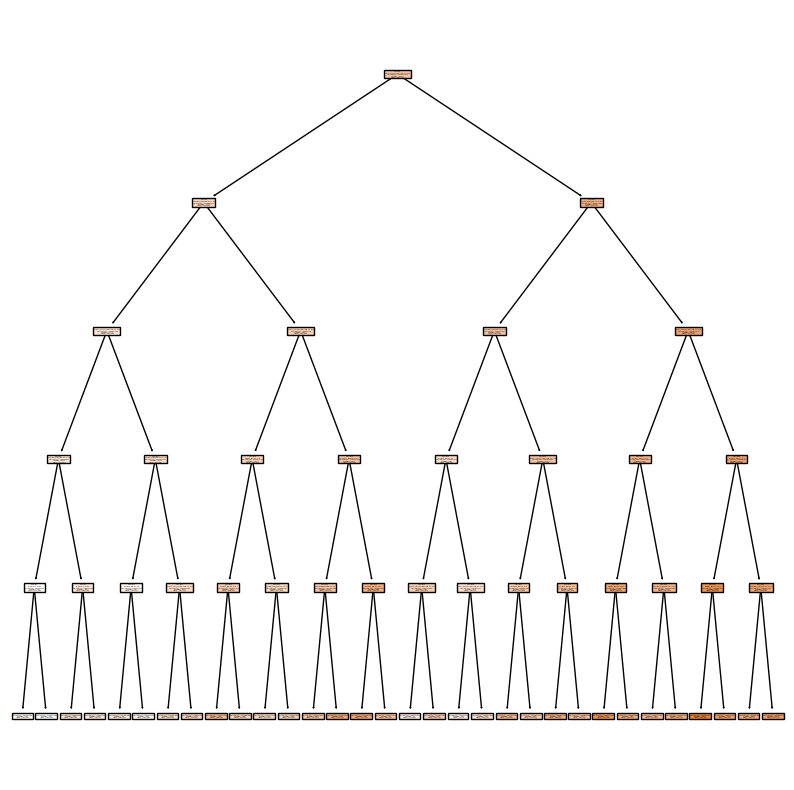

In [32]:
auto_feats = X_train.columns.tolist()

fig, ax = plt.subplots( figsize=(10,10) )

tree.plot_tree( tree_reg, feature_names=auto_feats, filled=True, node_ids=True, ax=ax )

In [33]:
# REVIEW PREDICTION - 1 LOW
index = idx_low
print( y_test.loc[[index]] )
print(tree_reg.predict( X_test.loc[[index]] ))
print( tree_reg.decision_path( X_test.loc[[index]] ))

11475    400
Name: monthly_rent, dtype: int64
[1358.05839416]
  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 6)	1


In [34]:
# REVIEW PREDICTION - 2 MID
index = idx_mid
print( "Actual Price:", y_test.loc[[index]] )
print( "Predicted Price:", tree_reg.predict( X_test.loc[[index]] ))
print( tree_reg.decision_path( X_test.loc[[index]] ))

Actual Price: 34397    2400
Name: monthly_rent, dtype: int64
Predicted Price: [2040.2047265]
  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 10)	1
  (0, 14)	1
  (0, 15)	1


In [35]:
# REVIEW PREDICTION - 2 HIGH
index = idx_high
print( "Actual Price:", y_test.loc[[index]] )
print( "Predicted Price:", tree_reg.predict( X_test.loc[[index]] ))
print( tree_reg.decision_path( X_test.loc[[index]] ))

Actual Price: 81913    6600
Name: monthly_rent, dtype: int64
Predicted Price: [3315.13187623]
  (0, 0)	1
  (0, 32)	1
  (0, 48)	1
  (0, 56)	1
  (0, 60)	1
  (0, 62)	1


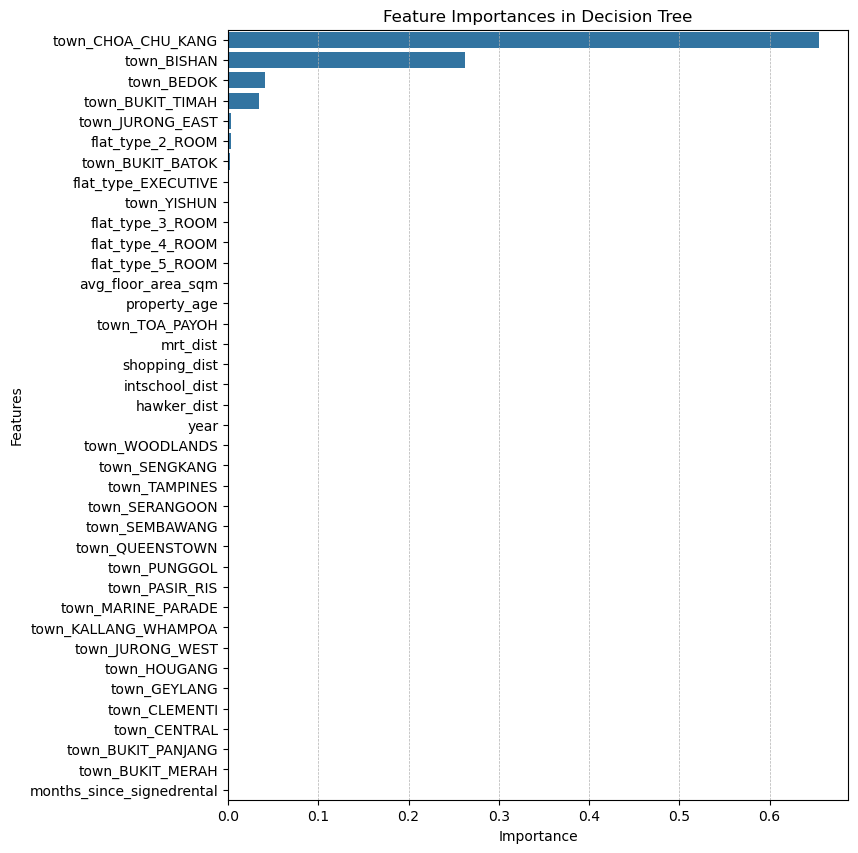

In [36]:
# feature_names contains the names of the features
feature_names = X.columns

# Get feature importances
importances = tree_reg.feature_importances_

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Create the bar plot of the features against their importance towards the prediction
plt.figure(figsize=(8, 10))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.barplot(feature_importances_df, x='Importance', y='Feature')
plt.title('Feature Importances in Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.show()

### MODEL: RANDOM FOREST

In [53]:
from sklearn.ensemble import RandomForestRegressor

rnd_clf = RandomForestRegressor( max_depth=10, random_state=rng )

rnd_clf.fit( X_train, y_train )

y_pred_rf = rnd_clf.predict( X_test )

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred_rf)

mae = mean_absolute_error(y_test, y_pred_rf)
                         
r2 = r2_score(y_test, y_pred_rf)

print('Mean Squared Error:', mse)

print('Mean Absolute Error:', mae)

print('R2 Score:', r2)


Mean Squared Error: 237060.19126584107
Mean Absolute Error: 371.950393560747
R2 Score: 0.5410236573659604


In [49]:
# REVIEW PREDICTION - 1 LOW
index = idx_low
print("Actual Value:", y_test[index])
print("Predicted Value:", rnd_clf.predict( X_test.loc[[index]] ))

Actual Value: 400
Predicted Value: [1349.94062401]


In [50]:
# REVIEW PREDICTION - 1 MID
index = idx_mid
print("Actual Value:", y_test[index])
print("Predicted Value:", rnd_clf.predict( X_test.loc[[index]] ))

Actual Value: 2400
Predicted Value: [1998.36271981]


In [51]:
# REVIEW PREDICTION - 1 HIGH
index = idx_high
print("Actual Value:", y_test[index])
print("Predicted Value:", rnd_clf.predict( X_test.loc[[index]] ))

Actual Value: 6600
Predicted Value: [3244.69575161]


### MODEL: Naive Bayes 

In [42]:
from sklearn.naive_bayes import GaussianNB

# Build a Gaussian Classifier
nb_model = GaussianNB()

# Model training
nb_model.fit(X_train, y_train)

# Predict Output
predicted = nb_model.predict(X_test)

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, predicted)

mae = mean_absolute_error(y_test, predicted)
                         
r2 = r2_score(y_test, predicted)

print('Mean Squared Error:', mse)

print('Mean Absolute Error:', mae)

print('R2 Score:', r2)


Mean Squared Error: 795139.7381578318
Mean Absolute Error: 700.8127718560298
R2 Score: -0.5394838203492864


In [44]:
# REVIEW PREDICTION - 1 LOW
index = idx_low
print("Actual Value:", y_test[index])
print("Predicted Value:", nb_model.predict( X_test.loc[[index]] ))

Actual Value: 400
Predicted Value: [400]


In [45]:
# REVIEW PREDICTION - 2 MID
index = idx_mid
print("Actual Value:", y_test[index])
print("Predicted Value:", nb_model.predict( X_test.loc[[index]] ))

Actual Value: 2400
Predicted Value: [1080]


In [46]:
# REVIEW PREDICTION - 2 HIGH
index = idx_high
print("Actual Value:", y_test[index])
print("Predicted Value:", nb_model.predict( X_test.loc[[index]] ))

Actual Value: 6600
Predicted Value: [3888]
